In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import xgboost

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [86]:
# on local machine
root_path = os.getcwd()
train_file_path = root_path + '/train.csv'
test_file_path = root_path + '/test.csv'

# on kaggle
# train_file_path = '/kaggle/input/spaceship-titanic/train.csv'
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)
# test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

In [ ]:
for col in train_df.columns:
    print(f"{col}: {train_df[col].unique().size}")

PassengerId: 8693

HomePlanet: 4

CryoSleep: 3

Cabin: 6561

Destination: 4

Age: 81

VIP: 3

RoomService: 1274

FoodCourt: 1508

ShoppingMall: 1116

Spa: 1328

VRDeck: 1307

Name: 8474

Transported: 2


In [88]:
irrelevant_cols = ["PassengerId", "Name", "Cabin"]
train_df.drop(columns = irrelevant_cols, axis = 1, inplace = True)


In [93]:
pid = test_df["PassengerId"].copy()
test_df.drop(columns = irrelevant_cols, axis = 1, inplace = True)

In [87]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_df["Transported"])
train_df["Transported"] = le.transform(train_df["Transported"])

In [ ]:
num_cols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
cat_cols = ['HomePlanet', "CryoSleep", "Destination", "VIP"]


In [ ]:
# log_cols = []
# for col in num_cols:
#     if col == "Age": continue
#     log_col = "log_" + col
#     train_df[log_col] = train_df[col].apply(lambda x: np.log(x + 1))
#     log_cols.append(log_col)

In [ ]:
train_df.describe()
# num_cols += log_cols

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  Transported  
count   8505.000000  8693.000000  
mean     304.854791     0.503624  
std     1145.717189     0.500016  
min        0.000000     0.000000  
25%        0.000000     0.000000  
50%        0.000000     1.000000  
75%       46.000000     1.000000  
max    24133.000000     1.000000

<Axes: xlabel='Age', ylabel='RoomService'>

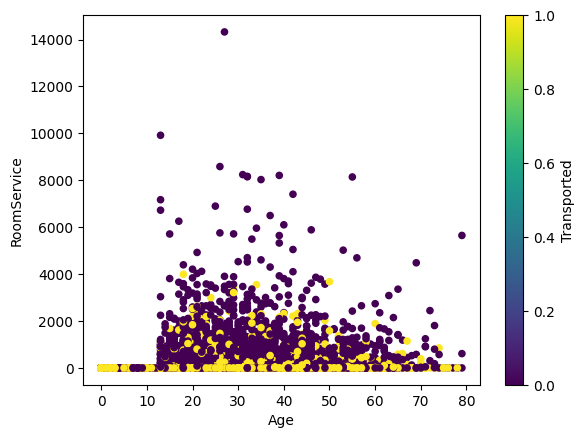

In [89]:
train_df.plot(kind ="scatter" , x = "Age", y = "RoomService", c = "Transported", cmap = "viridis" )

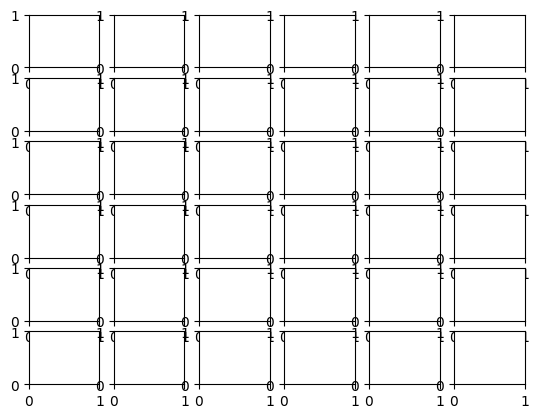

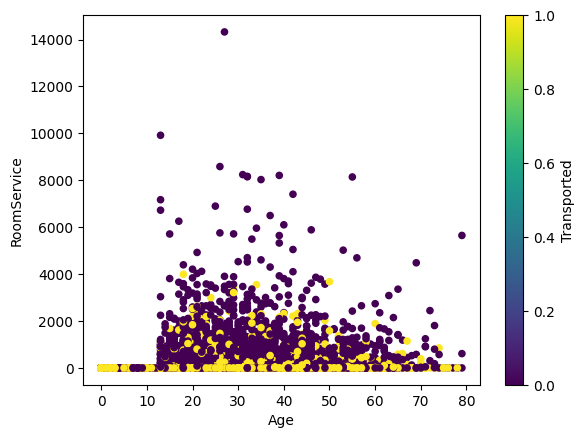

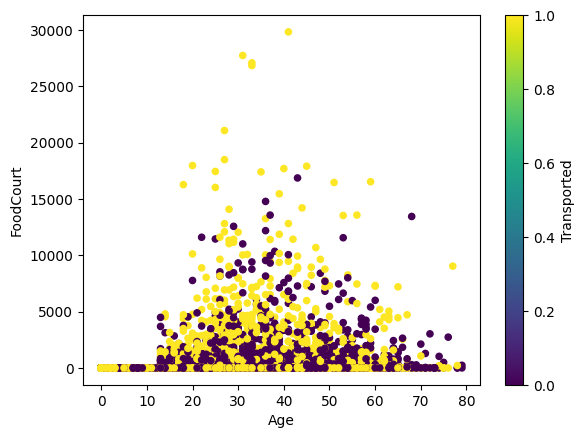

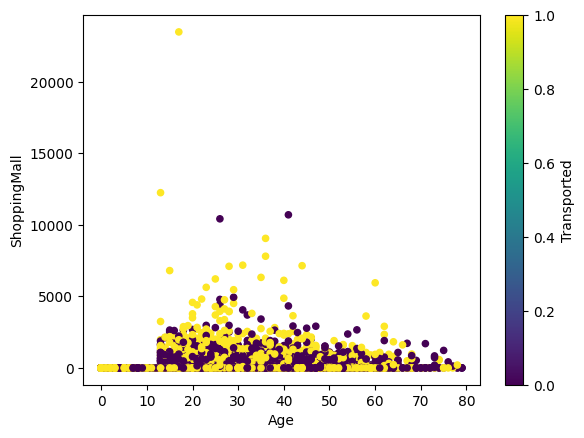

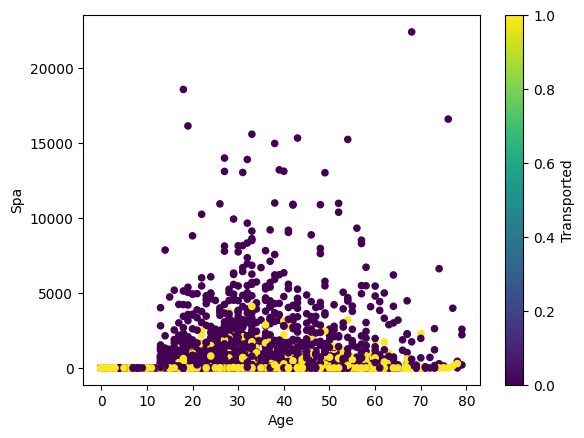

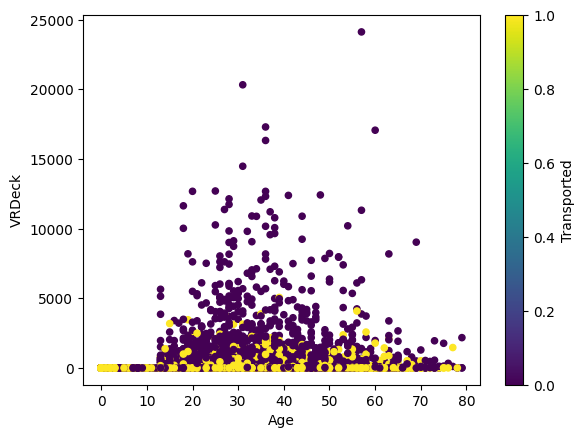

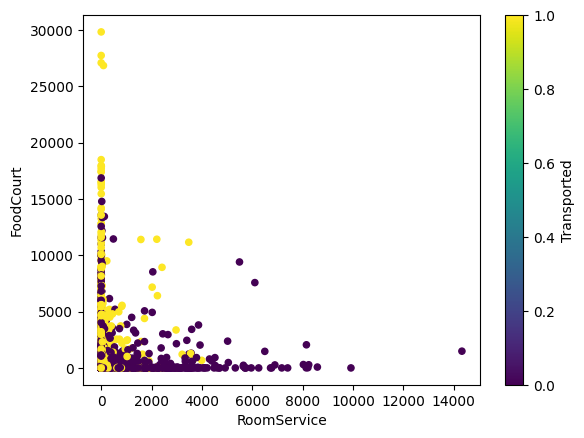

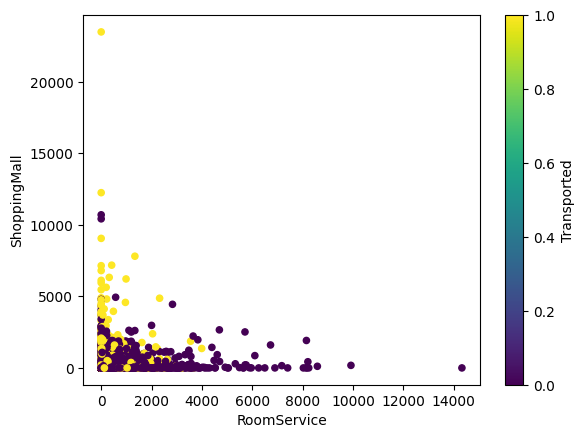

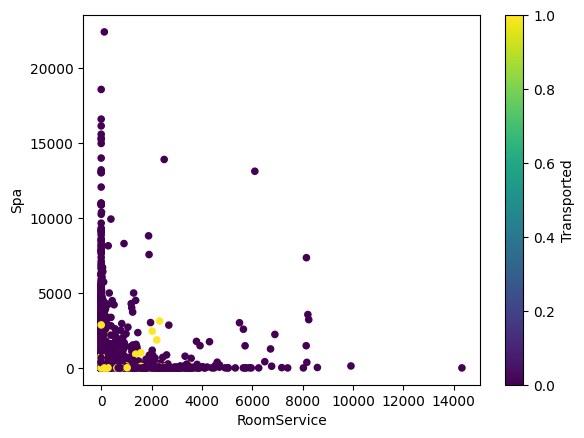

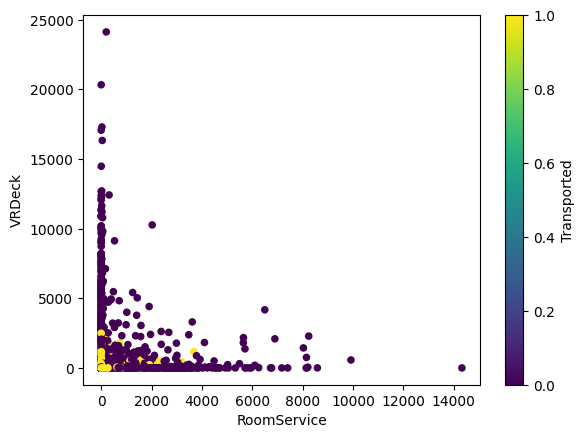

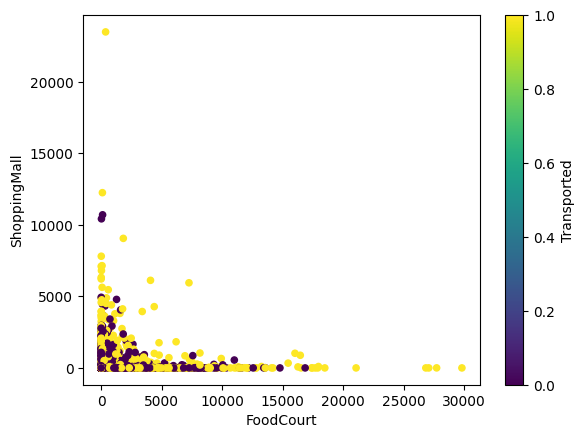

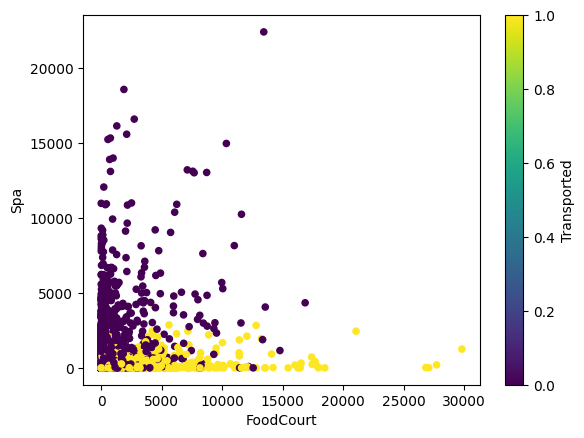

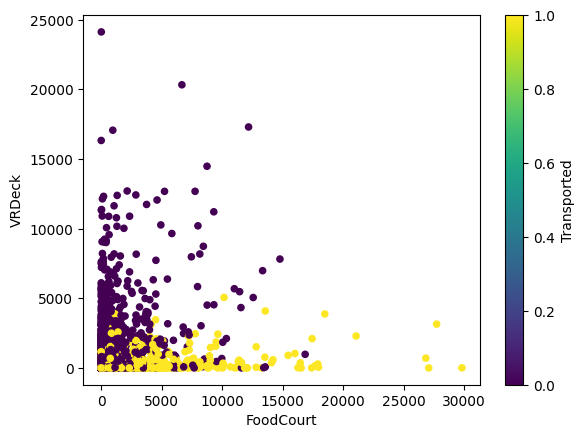

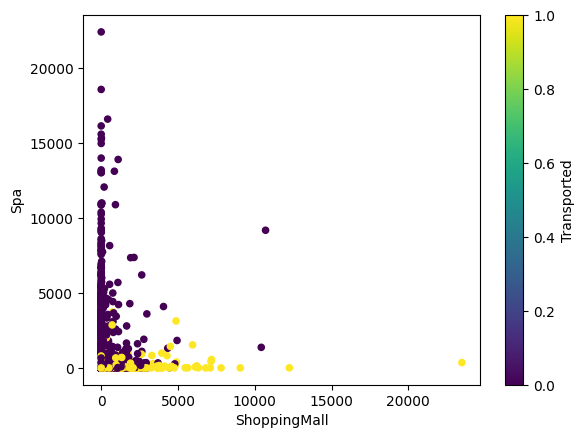

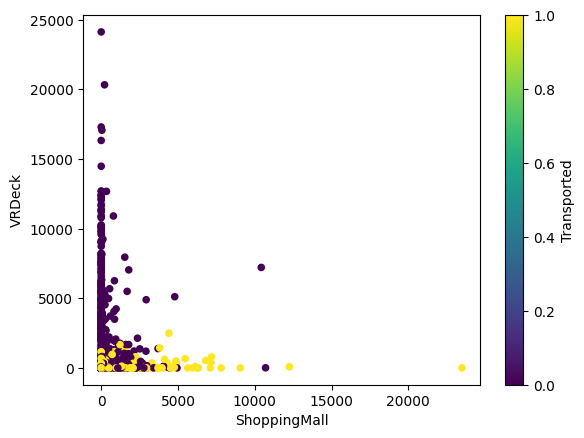

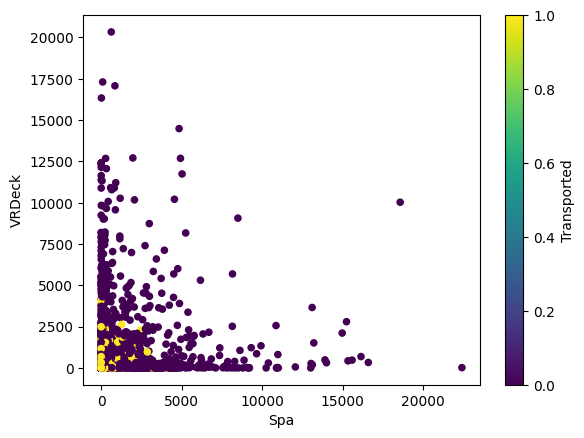

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(len(num_cols), len(num_cols))
for i, coli in enumerate(num_cols):
    for j, colj in enumerate(num_cols[i+1:]):
        axs[i, j] = train_df.plot(kind ="scatter" , x =  coli, y = colj, c = "Transported", cmap = "viridis" )

plt.show()

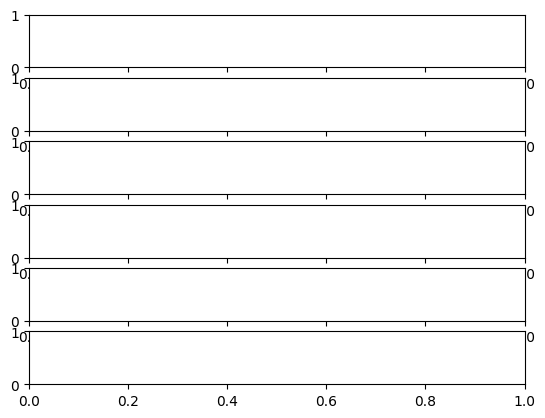

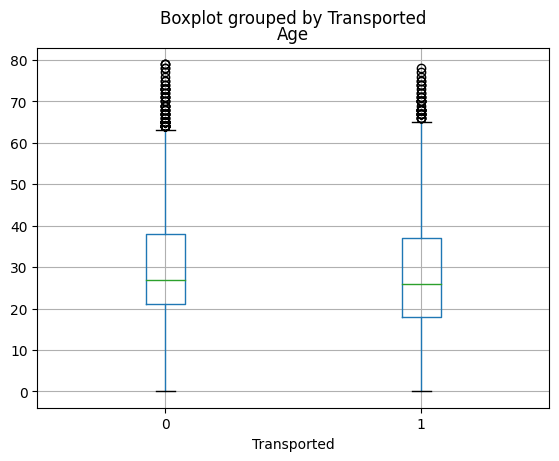

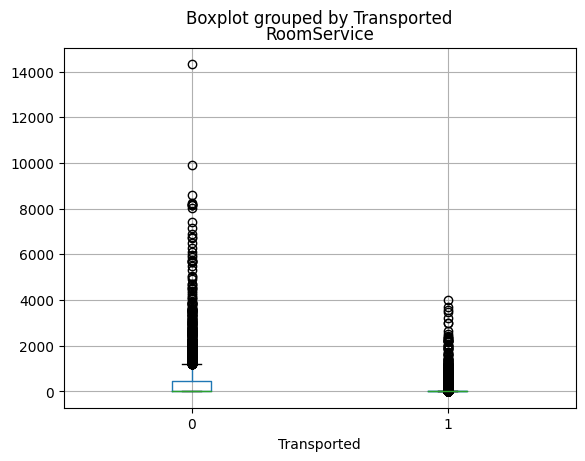

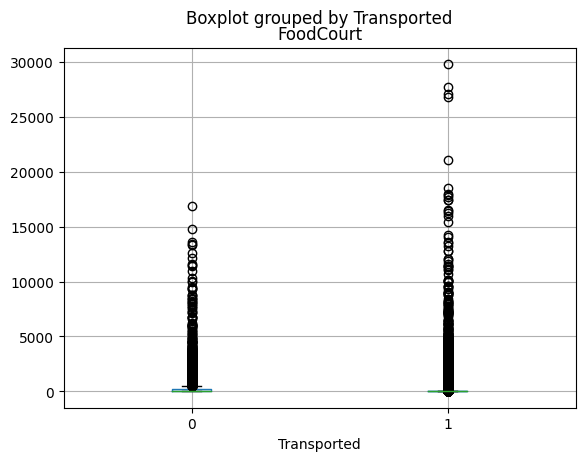

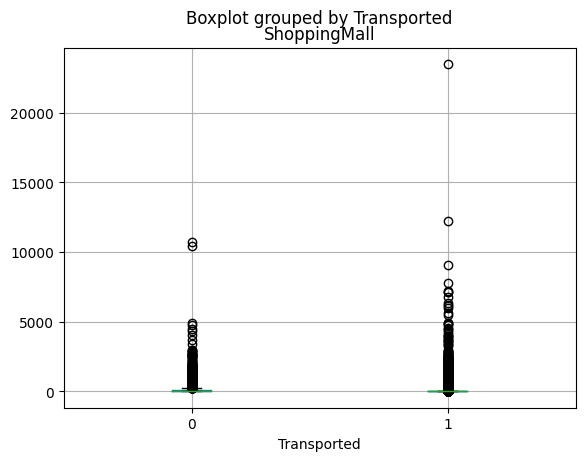

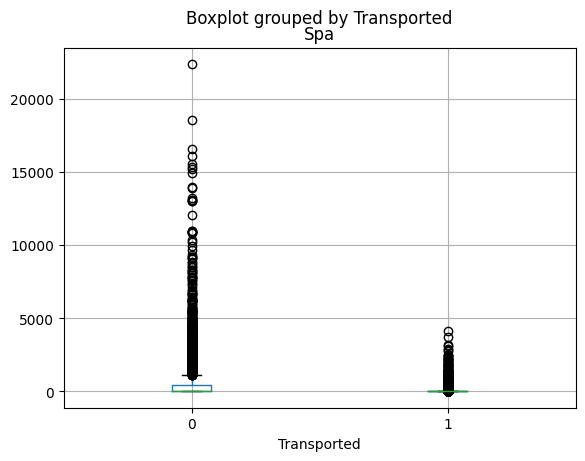

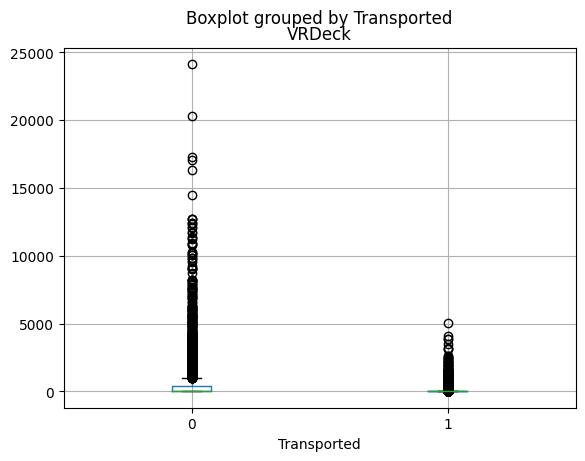

In [ ]:
# boxplot
fig, axs = plt.subplots(len(num_cols), 1)
for i, coli in enumerate(num_cols):
        axs[i] = train_df.boxplot(column = [coli], by = "Transported")
plt.show()

In [95]:
def bisect(df, col, threshold):
  low, high = 0, 1
  while low < high - 0.0001:
    mid = (low + high)/2
    if (df[df[col] <= df[col].quantile(mid)]).shape[0] >= threshold:
      high = mid
    else:
      low = mid
  return high


In [ ]:
train_df.dropna().shape

(6923, 11)

In [102]:
from sklearn.impute import SimpleImputer
for col in train_df.columns:
    if col == "Transported": continue
    strategy = "most_frequent" if col in cat_cols else "median"
    sim = SimpleImputer(strategy=strategy)
    res = sim.fit_transform(train_df[col].to_numpy().reshape(-1, 1))
    res2 = sim.transform(test_df[col].to_numpy().reshape(-1, 1))
    res = pd.DataFrame(res, columns = [col])
    res2 = pd.DataFrame(res2, columns = [col])
    train_df = pd.concat([train_df.drop(columns = [col], axis = 1), res], axis
    = 1)
    test_df = pd.concat([test_df.drop(columns = [col], axis = 1), res2], axis
    = 1)


In [ ]:
train_df.dropna().shape

(8693, 11)

In [ ]:
train_df_cp = train_df.copy()

In [ ]:
train_df = train_df_cp.copy()
print(train_df.shape)

for col in num_cols:
  q = bisect(train_df_cp, col, 0.99*train_df_cp.shape[0])
  train_df = train_df[train_df[col] <= train_df[col].quantile(q)]

train_df.shape

(8693, 11)


(8189, 11)

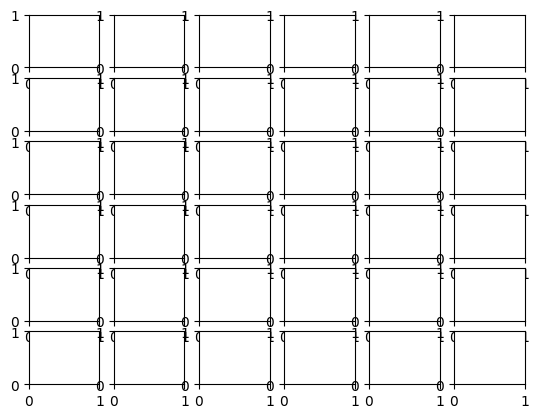

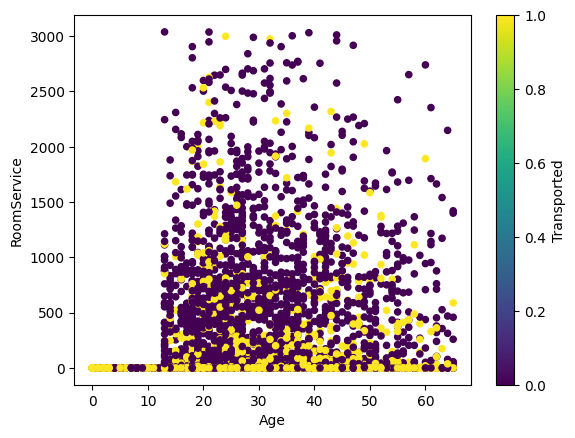

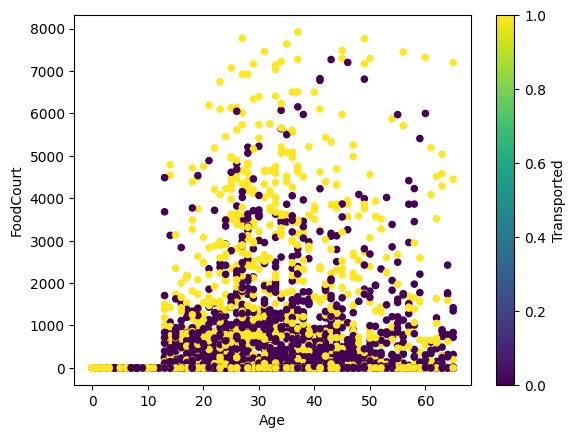

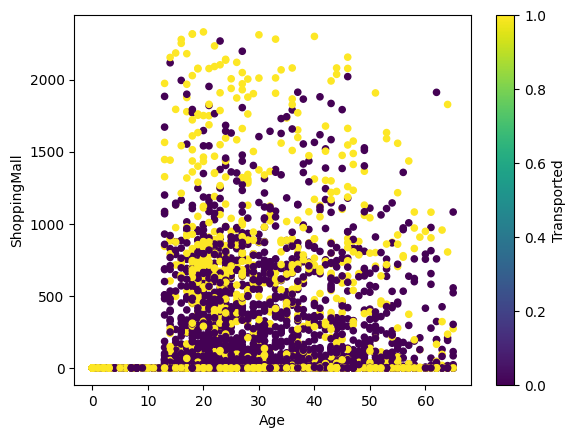

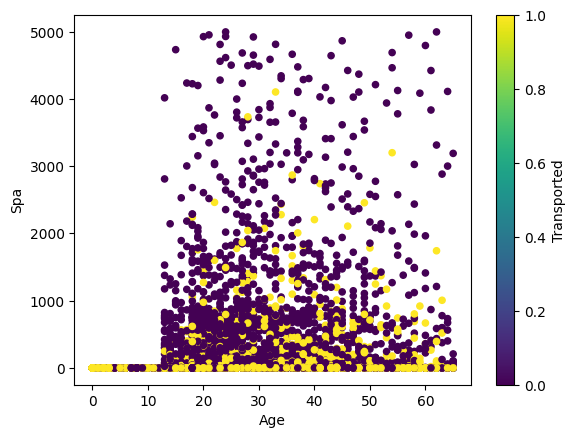

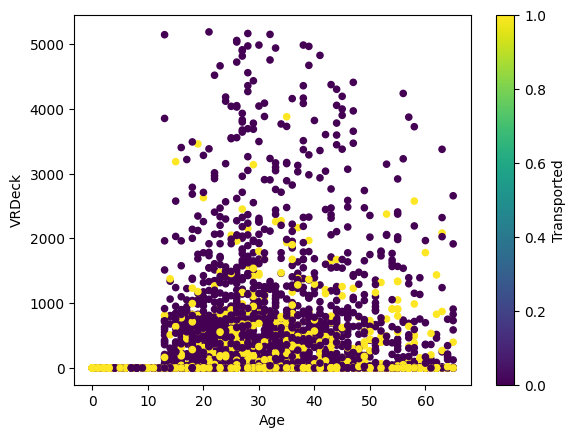

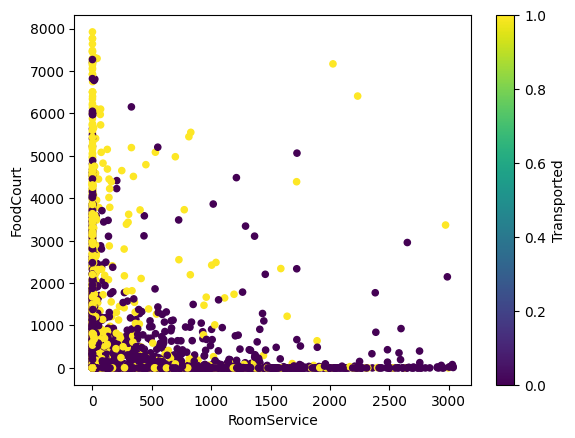

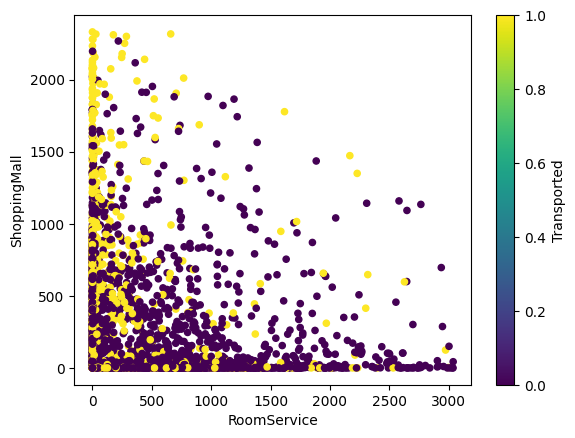

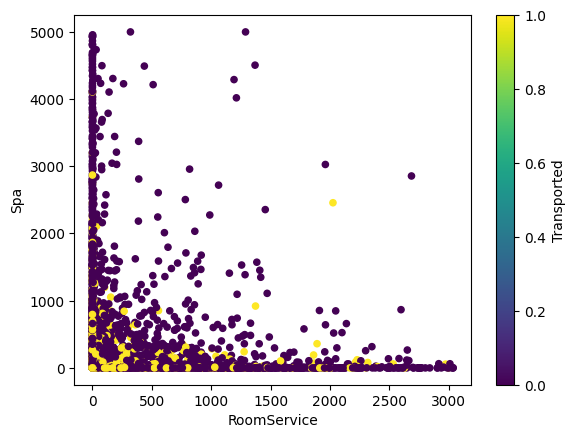

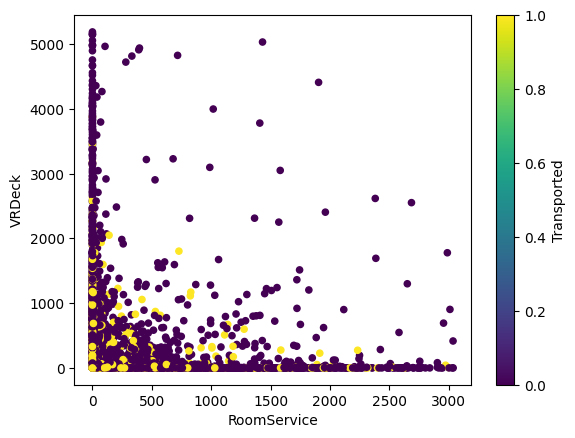

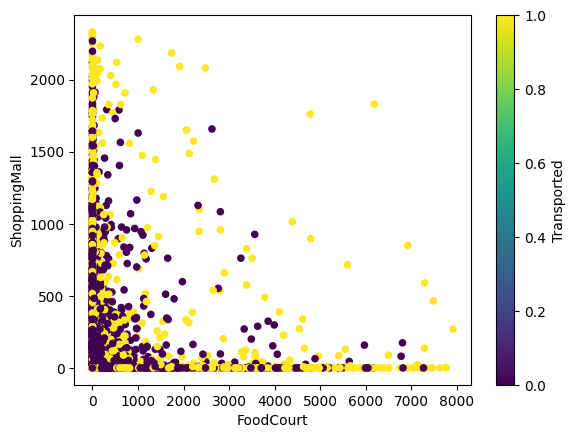

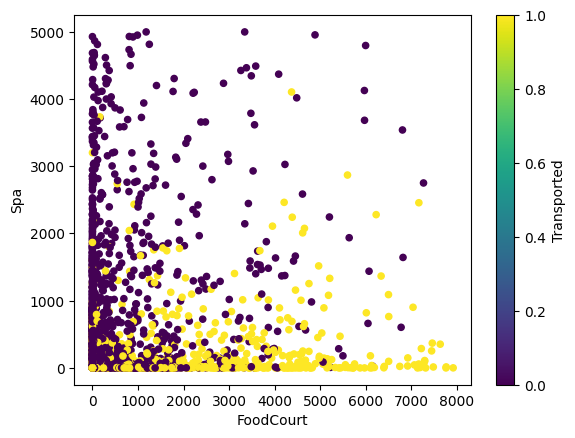

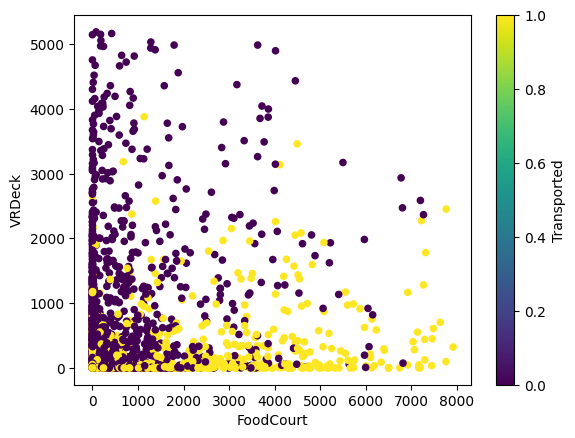

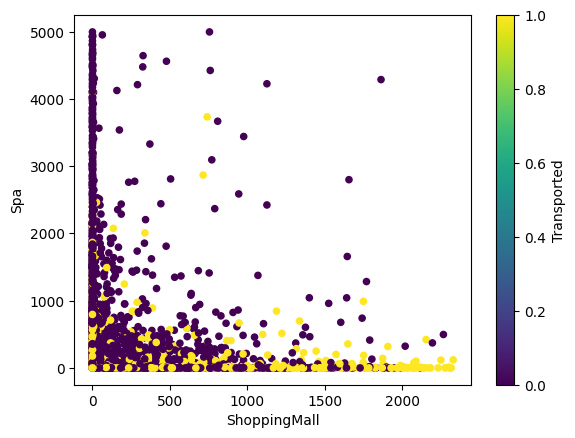

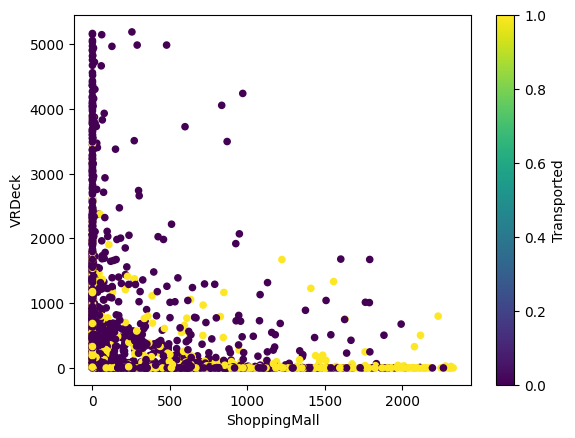

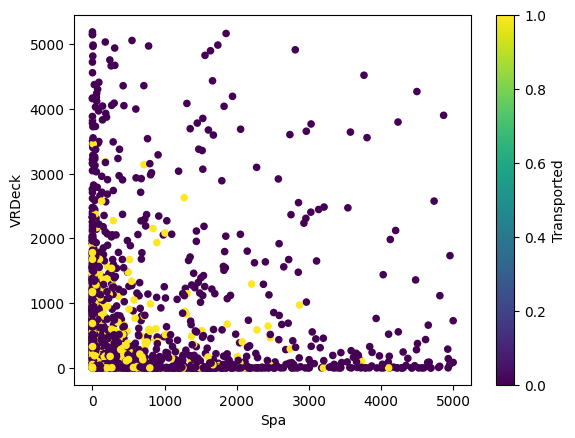

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(len(num_cols), len(num_cols))
for i, coli in enumerate(num_cols):
    for j, colj in enumerate(num_cols[i+1:]):
        axs[i, j] = train_df.plot(kind ="scatter" , x =  coli, y = colj, c = "Transported", cmap = "viridis" )

plt.show()

In [81]:
train_df.dropna().shape

HomePlanet CryoSleep  Destination   Age    VIP  RoomService  FoodCourt  \
0      Earth      True  TRAPPIST-1e  27.0  False          0.0        0.0   
1      Earth     False  TRAPPIST-1e  19.0  False          0.0        9.0   
2     Europa      True  55 Cancri e  31.0  False          0.0        0.0   
3     Europa     False  TRAPPIST-1e  38.0  False          0.0     6652.0   
4      Earth     False  TRAPPIST-1e  20.0  False         10.0        0.0   

   ShoppingMall     Spa  VRDeck  
0           0.0     0.0     0.0  
1           0.0  2823.0     0.0  
2           0.0     0.0     0.0  
3           0.0   181.0   585.0  
4         635.0     0.0     0.0

In [ ]:
from sklearn.preprocessing import OneHotEncoder
for col in cat_cols:
    ohe = OneHotEncoder()
    res = ohe.fit_transform(train_df[col].to_numpy().reshape(-1, 1))
    res = pd.DataFrame(res.todense(), columns = ohe.get_feature_names_out(input_features = [col]))
    main_df = train_df.drop(columns = [col], axis = 1).reset_index(drop = True)
    res = res.reset_index(drop = True)
    train_df = pd.concat([main_df, res], axis = 1)


In [103]:
for col in cat_cols:
    ohe = OneHotEncoder()
    res = ohe.fit_transform(test_df[col].to_numpy().reshape(-1, 1))
    res = pd.DataFrame(res.todense(), columns = ohe.get_feature_names_out(input_features = [col]))
    main_df = test_df.drop(columns = [col], axis = 1).reset_index(drop = True)
    res = res.reset_index(drop = True)
    test_df = pd.concat([main_df, res], axis = 1)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
train_df_pca = pca.fit_transform(X = train_df.drop(columns =["Transported"], axis = 1), y = train_df['Transported'])
train_df_pca = pd.DataFrame(train_df_pca, columns = pca.get_feature_names_out(input_features = train_df.drop(columns = ["Transported"], axis = 1).columns))
train_df_pca = pd.concat([train_df_pca, train_df['Transported']], axis = 1)

In [ ]:
y_train = train_df_pca.pop("Transported")

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
res = scaler.fit_transform(X = train_df_pca, y = y_train)
train_df_pca = pd.DataFrame(res, columns=scaler.get_feature_names_out(input_features=train_df_pca.columns))


In [ ]:
pd.concat([train_df_pca, y_train], axis = 1).corr()["Transported"]

pca0          -0.019270
pca1          -0.339190
pca2          -0.052870
pca3          -0.301063
pca4          -0.005269
pca5          -0.006737
pca6          -0.384058
pca7           0.014185
pca8           0.064991
pca9           0.063562
Transported    1.000000
Name: Transported, dtype: float64

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

mp = {

    "random_forest": {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [10, 20, 40, 80, 160],
            'max_depth': [1, 2, 4, 8, 16]
        },
    },

    "xgb":{
        'model': XGBClassifier(),
        'params': {

        },
    },

    "logistic": {
        'model':LogisticRegression(),
        'params': {
            'penalty': ['l1', 'l2']
        }
    },

    }

In [ ]:
score = {}
print(f"fitting  {len(mp.items())} items")
for name, config in mp.items():
    print("training",  name)
    model = config['model']
    grid = config['params']
    search = GridSearchCV(estimator = model, param_grid = grid, cv = 3)
    search.fit(train_df_pca, y_train)
    score[name] = {
        'score': search.best_score_,
        'best_params': search.best_params_,
    }
    print(f'training {name} done')

fitting  3 items

training random_forest


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast

  _data = np.array(data, dtype=dtype, copy=copy,


training random_forest done

training xgb

training xgb done

training logistic

training logistic done


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 

3 fits failed out of a total of 6.

The score on these train-test partitions for these parameters will be set to nan.

If these failures are not expected, you can try to debug them by setting error_score='raise'.



Below are more details about the failures:

--------------------------------------------------------------------------------

3 fits failed with the following error:

Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper

    return fit_method(estimator, *args, **kwargs)

  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit

    solver = _check_solver(self.solver, self.penalty, self.dual)


In [ ]:
score

{'random_forest': {'score': 0.7908182408365626,
  'best_params': {'max_depth': 8, 'n_estimators': 80}},
 'xgb': {'score': 0.7779962962813824, 'best_params': {}},
 'logistic': {'score': 0.7755538016805881, 'best_params': {'penalty': 'l2'}}}

In [ ]:
from sklearn.model_selection import cross_val_score
clf = SVC(kernel = 'linear', gamma = 2, degree = 5, coef0=1, C = 0.1)

scores = cross_val_score(clf, train_df_pca, y_train, cv = 5)


In [ ]:
scores

array([0.77167277, 0.76923077, 0.77289377, 0.77167277, 0.78497251])

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

rf_clf = RandomForestClassifier(n_estimators =80, max_depth = 8)
xgb_clf = XGBClassifier()
svc_poly_clf = SVC(kernel = 'poly', degree = 3, coef0=1, C = 1)
svc_linear_clf = SVC(kernel = 'linear')
logistic_clf = LogisticRegression(penalty = 'l2')

voting_clf = VotingClassifier(
    estimators = [
        ('rf', rf_clf),
        ('xgb', xgb_clf),
        ('svc_poly', svc_poly_clf),
        ('svc_linear', svc_linear_clf),
        ('logistic', logistic_clf)
    ],
    voting = 'hard'
)
scores = cross_val_score(voting_clf, train_df_pca, y_train, cv = 5)
# voting_clf.fit(train_df_pca, y_train)



array([[<Axes: xlabel='pca0', ylabel='pca0'>,
        <Axes: xlabel='pca1', ylabel='pca0'>,
        <Axes: xlabel='pca2', ylabel='pca0'>,
        <Axes: xlabel='pca3', ylabel='pca0'>,
        <Axes: xlabel='pca4', ylabel='pca0'>,
        <Axes: xlabel='pca5', ylabel='pca0'>,
        <Axes: xlabel='pca6', ylabel='pca0'>,
        <Axes: xlabel='pca7', ylabel='pca0'>,
        <Axes: xlabel='pca8', ylabel='pca0'>,
        <Axes: xlabel='pca9', ylabel='pca0'>],
       [<Axes: xlabel='pca0', ylabel='pca1'>,
        <Axes: xlabel='pca1', ylabel='pca1'>,
        <Axes: xlabel='pca2', ylabel='pca1'>,
        <Axes: xlabel='pca3', ylabel='pca1'>,
        <Axes: xlabel='pca4', ylabel='pca1'>,
        <Axes: xlabel='pca5', ylabel='pca1'>,
        <Axes: xlabel='pca6', ylabel='pca1'>,
        <Axes: xlabel='pca7', ylabel='pca1'>,
        <Axes: xlabel='pca8', ylabel='pca1'>,
        <Axes: xlabel='pca9', ylabel='pca1'>],
       [<Axes: xlabel='pca0', ylabel='pca2'>,
        <Axes: xlabel='pca1', yl

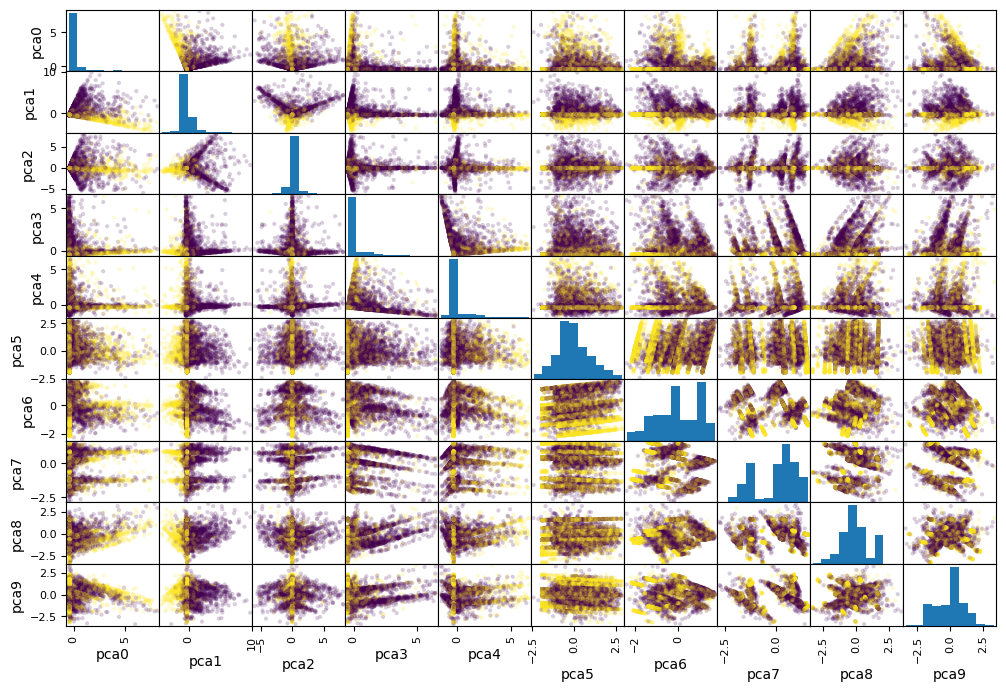

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(train_df_pca, alpha = 0.2, c = y_train, figsize = (12, 8))

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
kmeans = KMeans(n_clusters = 7)
kmeans.fit(train_df_pca)

KMeans(n_clusters=7)

In [ ]:
cluster = pd.DataFrame(kmeans.predict(train_df_pca), columns = ["cluster"])
oe = OneHotEncoder()
res = oe.fit_transform(cluster)
res = pd.DataFrame(res.todense(), columns = oe.get_feature_names_out(input_features = ["cluster"]))

In [60]:
train_df_clustered = pd.concat([train_df_pca, res], axis = 1)
raw_clustered_df = pd.concat([train_df, res], axis = 1)
y_train = raw_clustered_df.pop("Transported")

In [106]:
test_pca = pca.transform(X = test_df)
test_pca = pd.DataFrame(test_pca, columns = pca.get_feature_names_out(input_features = test_df.columns))

test_clustered = pd.DataFrame(kmeans.predict(test_pca), columns = ["cluster"])
oe = OneHotEncoder()
res = oe.fit_transform(test_clustered)
res = pd.DataFrame(res.todense(), columns = oe.get_feature_names_out(input_features = ["cluster"]))

test_clustered_df = pd.concat([test_df, res], axis = 1)
test_clustered_df.head()

Age  RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  \
0  27.0          0.0        0.0           0.0     0.0     0.0   
1  19.0          0.0        9.0           0.0  2823.0     0.0   
2  31.0          0.0        0.0           0.0     0.0     0.0   
3  38.0          0.0     6652.0           0.0   181.0   585.0   
4  20.0         10.0        0.0         635.0     0.0     0.0   

   HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  CryoSleep_False  ...  \
0               1.0                0.0              0.0              0.0  ...   
1               1.0                0.0              0.0              1.0  ...   
2               0.0                1.0              0.0              0.0  ...   
3               0.0                1.0              0.0              1.0  ...   
4               1.0                0.0              0.0              1.0  ...   

   Destination_PSO J318.5-22  Destination_TRAPPIST-1e  VIP_False  VIP_True  \
0                        0.0                      1.0        1.0       0.0   
1                        0.0                      1.0        1.0       0.0   
2                        0.0                      0.0        1.0       0.0   
3                        0.0                      1.0        1.0       0.0   
4                        0.0                      1.0        1.0       0.0   

   cluster_0  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  
0        0.0        0.0        0.0        0.0        0.0        1.0  
1        1.0        0.0        0.0        0.0        0.0        0.0  
2        0.0        0.0        0.0        0.0        0.0        1.0  
3        0.0        0.0        0.0        0.0        1.0        0.0  
4        0.0        0.0        1.0        0.0        0.0        0.0  

[5 rows x 22 columns]

In [61]:
score = {}
print(f"fitting  {len(mp.items())} items")
for name, config in mp.items():
    print("training",  name)
    model = config['model']
    grid = config['params']
    search = GridSearchCV(estimator = model, param_grid = grid, cv = 3)
    search.fit(raw_clustered_df, y_train)
    score[name] = {
        'score': search.best_score_,
        'best_params': search.best_params_,
    }
    print(f'training {name} done')

fitting  3 items

training random_forest

training random_forest done

training xgb

training xgb done

training logistic


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



Increase the number of iterations (max_iter) or scale the data as shown in:

    https://scikit-learn.org/stable/modules/preprocessing.html

Please also refer to the documentation for alternative solver options:

    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

  n_iter_i = _check_optimize_result(

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



Increase the number of iterations (max_iter) or scale the data as shown in:

    https://scikit-learn.org/stable/modules/preprocessing.html

Please also refer to the documentation for alternative solver options:

    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



training logistic done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



Increase the number of iterations (max_iter) or scale the data as shown in:

    https://scikit-learn.org/stable/modules/preprocessing.html

Please also refer to the documentation for alternative solver options:

    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

  n_iter_i = _check_optimize_result(

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 

3 fits failed out of a total of 6.

The score on these train-test partitions for these parameters will be set to nan.

If these failures are not expected, you can try to debug them by setting error_score='raise'.



Below are more details about the failures:

--------------------------------------------------------------------------------

3 fits failed with the following er

In [109]:
raw_clustered_df.columns

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'CryoSleep_False', 'CryoSleep_True', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'VIP_False',
       'VIP_True', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3',
       'cluster_4', 'cluster_5', 'cluster_6'],
      dtype='object')

In [114]:
test_clustered_df["cluster_1"] = 0.0
test_clustered_df.head()

# move new column after cluster_0
new_col = test_clustered_df.pop("cluster_1")
test_clustered_df.insert(17, "cluster_1", new_col)

AssertionError: 

In [63]:
scaler = StandardScaler()
res = scaler.fit_transform(X = raw_clustered_df, y = y_train)
res = pd.DataFrame(res, columns=scaler.get_feature_names_out(input_features=raw_clustered_df.columns))

In [127]:
res2 = scaler.fit_transform(test_clustered_df)
res2 = pd.DataFrame(res2, columns=scaler.get_feature_names_out(input_features=test_clustered_df.columns))


In [128]:
res2

Age  RoomService  FoodCourt  ShoppingMall       Spa    VRDeck  \
0    -0.115689    -0.357339  -0.283840     -0.312173 -0.267841 -0.246712   
1    -0.685986    -0.357339  -0.277879     -0.312173  2.287504 -0.246712   
2     0.169459    -0.357339  -0.283840     -0.312173 -0.267841 -0.246712   
3     0.668469    -0.357339   4.121518     -0.312173 -0.104002  0.226648   
4    -0.614699    -0.340723  -0.283840      0.832122 -0.267841 -0.246712   
...        ...          ...        ...           ...       ...       ...   
4272  0.383320    -0.357339  -0.283840     -0.312173 -0.267841 -0.246712   
4273  0.953617    -0.357339   0.277095     -0.281538 -0.258790 -0.130193   
4274 -0.115689    -0.357339  -0.283840     -0.312173 -0.267841 -0.246712   
4275 -0.115689    -0.357339   1.491019     -0.312173 -0.267841  0.176479   
4276  1.024904    -0.357339  -0.283840     -0.312173 -0.267841 -0.246712   

      HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  CryoSleep_False  \
0             0.905539          -0.553131        -0.525314        -1.330443   
1             0.905539          -0.553131        -0.525314         0.751630   
2            -1.104315           1.807889        -0.525314        -1.330443   
3            -1.104315           1.807889        -0.525314         0.751630   
4             0.905539          -0.553131        -0.525314         0.751630   
...                ...                ...              ...              ...   
4272          0.905539          -0.553131        -0.525314        -1.330443   
4273          0.905539          -0.553131        -0.525314         0.751630   
4274         -1.104315          -0.553131         1.903624        -1.330443   
4275         -1.104315           1.807889        -0.525314         0.751630   
4276          0.905539          -0.553131        -0.525314        -1.330443   

      ...  Destination_TRAPPIST-1e  VIP_False  VIP_True  cluster_0  cluster_1  \
0     ...                 0.634992   0.132689 -0.132689  -0.238395        0.0   
1     ...                 0.634992   0.132689 -0.132689   4.194717        0.0   
2     ...                -1.574822   0.132689 -0.132689  -0.238395        0.0   
3     ...                 0.634992   0.132689 -0.132689  -0.238395        0.0   
4     ...                 0.634992   0.132689 -0.132689  -0.238395        0.0   
...   ...                      ...        ...       ...        ...        ...   
4272  ...                 0.634992   0.132689 -0.132689  -0.238395        0.0   
4273  ...                 0.634992   0.132689 -0.132689  -0.238395        0.0   
4274  ...                -1.574822   0.132689 -0.132689  -0.238395        0.0   
4275  ...                 0.634992   0.132689 -0.132689  -0.238395        0.0   
4276  ...                -1.574822   0.132689 -0.132689  -0.238395        0.0   

      cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  
0     -0.420642  -0.313168  -0.378923  -0.414077   1.140482  
1     -0.420642  -0.313168  -0.378923  -0.414077  -0.876822  
2     -0.420642  -0.313168  -0.378923  -0.414077   1.140482  
3     -0.420642  -0.313168  -0.378923   2.415009  -0.876822  
4     -0.420642   3.193170  -0.378923  -0.414077  -0.876822  
...         ...        ...        ...        ...        ...  
4272  -0.420642  -0.313168  -0.378923  -0.414077   1.140482  
4273  -0.420642  -0.313168  -0.378923   2.415009  -0.876822  
4274  -0.420642  -0.313168  -0.378923  -0.414077   1.140482  
4275  -0.420642  -0.313168  -0.378923   2.415009  -0.876822  
4276  -0.420642  -0.313168  -0.378923  -0.414077   1.140482  

[4277 rows x 23 columns]

In [65]:
scaled_raw_clustered_df = res.copy()


In [66]:
from sklearn.model_selection import cross_val_score
clf = SVC(kernel = 'poly', gamma = 1, degree = 2, coef0=1, C = 0.1)

scores = cross_val_score(clf, scaled_raw_clustered_df, y_train, cv = 3, verbose = True)


In [67]:
scores, scores.mean()

(array([0.77142857, 0.77545788, 0.78417003]), 0.7770188241789562)

In [68]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

rf_clf = RandomForestClassifier(n_estimators =80, max_depth = 160)
xgb_clf = XGBClassifier()
svc_poly_clf = SVC(kernel = 'poly', degree = 3, coef0=1, C = 1)
svc_linear_clf = SVC(kernel = 'linear')
logistic_clf_l2 = LogisticRegression(penalty = 'l2')
logistic_clf_l1 = LogisticRegression(penalty = 'l1', solver = 'liblinear')

voting_clf = VotingClassifier(
    estimators = [
        ('rf', rf_clf),
        ('xgb', xgb_clf),
        ('svc_poly', svc_poly_clf),
        ('svc_linear', svc_linear_clf),
        ('logistic_l2', logistic_clf_l2),
        ('logistic_l1', logistic_clf_l1)
    ],
    voting = 'hard'
)
scores = cross_val_score(voting_clf, scaled_raw_clustered_df, y_train, cv = 5)



In [69]:
scores, scores.mean()

(array([0.78021978, 0.77777778, 0.78083028, 0.78998779, 0.79841173]),
 0.7854454715175546)

In [70]:
voting_clf_v2 = VotingClassifier(
    estimators = [
        ('rf', rf_clf),
        ('xgb', xgb_clf),
        ('svc_poly', svc_poly_clf),
        ('svc_linear', svc_linear_clf),
        ('logistic_l2', logistic_clf_l2),
        ('logistic_l1', logistic_clf_l1)
    ],
    voting = 'hard'
)
voting_clf_v2.fit(scaled_raw_clustered_df, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=160,
                                                     n_estimators=80)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,...
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('svc_poly', SVC(C=1, coef0=1, kernel='poly')),
                             ('svc_linear', SVC(kernel='linear')),
                             ('logistic_l2', LogisticRegression()),
                             ('logistic_l1',
                              LogisticRegression(penalty='l1',
                                                 solver='liblinear'))])

In [129]:
pred = voting_clf_v2.predict(res2)

In [150]:
submisson = pd.merge(pid, pd.DataFrame(pred, columns = ["Transported"]), left_index=True, right_index = True)
submisson["Transported"] = submisson["Transported"].apply(lambda x: "True" if x == 1.0 else "False")
submisson.reset_index(drop = True, inplace = True)
submisson.to_csv("submission.csv", index = False)


In [148]:
submisson

PassengerId  Transported
0        0013_01          1.0
1        0018_01          0.0
2        0019_01          1.0
3        0021_01          1.0
4        0023_01          0.0
...          ...          ...
4272     9266_02          1.0
4273     9269_01          0.0
4274     9271_01          1.0
4275     9273_01          1.0
4276     9277_01          1.0

[4277 rows x 2 columns]